load library

In [1]:
from common.h36m_dataset import Human36mDataset
from common.camera import *

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import numpy as np
import torch

%matplotlib inline

load data

In [2]:
dataset = Human36mDataset("./data/data_3d_h36m.npz")
keypoints = np.load('./data/data_2d_h36m_cpn_ft_h36m_dbb.npz', allow_pickle = True)
keypoints = keypoints['positions_2d'].item()

In [3]:
viz_subject = "S1"
viz_action = "Walking 1"

fetch data

In [4]:
cam_0 = dataset.cameras()[viz_subject][0]
cam_1 = dataset.cameras()[viz_subject][1]
cam_2 = dataset.cameras()[viz_subject][2]
cam_3 = dataset.cameras()[viz_subject][3]

keypoints_2d_cam_0 = keypoints[viz_subject][viz_action][0].copy()
keypoints_2d_cam_1 = keypoints[viz_subject][viz_action][1].copy()
keypoints_2d_cam_2 = keypoints[viz_subject][viz_action][2].copy()
keypoints_2d_cam_3 = keypoints[viz_subject][viz_action][3].copy()

gt = dataset._data[viz_subject][viz_action]['positions'].copy()

skeleton = dataset.skeleton()

process data and select data

In [5]:
gt_cam_0 = world_to_camera(gt, R=cam_0['orientation'], t=cam_0['translation'])
gt_cam_1 = world_to_camera(gt, R=cam_1['orientation'], t=cam_1['translation'])
gt_cam_2 = world_to_camera(gt, R=cam_2['orientation'], t=cam_2['translation'])
gt_cam_3 = world_to_camera(gt, R=cam_3['orientation'], t=cam_3['translation'])

In [6]:
def reprojection(gt_cam, cam):
    return project_to_2d(torch.from_numpy(gt_cam.reshape(1, 17, 3)), torch.from_numpy(cam["intrinsic"].reshape(-1,9))).numpy()[0]

In [9]:
def display_2D_skeleton_beta(ax, keypoints, skeleton, img=None):
    line_segs = []
    cols = []
    for j, j_parent in enumerate(skeleton.parents()):    
        if j_parent == -1:
            continue
    
        if len(skeleton.parents()) == keypoints.shape[0]:
            col = 'red' if j in skeleton.joints_right() else 'black'
            cols.append(col)  
            line_segs.append([(keypoints[j, 0], keypoints[j, 1]), (keypoints[j_parent, 0], keypoints[j_parent, 1])])
            
    lc = LineCollection(line_segs, colors = cols, linewidths=2)
    
    ax.scatter(keypoints[:,0], keypoints[:,1])
    
    if img is None:
        # xlims, ylims
        top = keypoints[:,1].min() - 0.1
        left = keypoints[:,0].min() - 0.1
        bottom = keypoints[:,1].max() + 0.1
        right = keypoints[:,0].max() + 0.1
        ax.set_ylim(top, bottom)
        ax.set_xlim(left, right)
        ax.invert_yaxis()
        
    else:
        ax.imshow(img)

    ax.add_collection(lc)
    
    return ax

In [8]:
def display_3D_skeleton_beta(ax_3d, pos, skeleton, cams=None):
    line_3d_segs = []
    cols = []
    for j, j_parent in enumerate(skeleton.parents()):
        if j_parent == -1:
            continue

        col = 'red' if j in skeleton.joints_right() else 'black'
        cols.append(col)
        line_3d_segs.append([(pos[j, 0], pos[j, 1], pos[j, 2]), (pos[j_parent, 0], pos[j_parent, 1], pos[j_parent, 2])])
        
    lc = Line3DCollection(line_3d_segs, colors=cols, linewidths=2)
    
    ax_3d.add_collection3d(lc, zdir='z')      
    ax_3d.view_init(elev=15., azim=60)
#    ax_3d.set_aspect('equal')
#     ax_3d.set_xlabel("x")
#     ax_3d.set_ylabel("y")
#     ax_3d.set_zlabel("z")
#     ax_3d.set_xlim3d([-4, 6])
#     ax_3d.set_ylim3d([-4, 6])
#     ax_3d.set_zlim3d([-4, 6])
    ax_3d.auto_scale_xyz([-4, 6],[-4, 6],[-4, 6])

    ax_3d.dist = 9
    
    if cams is not None:
        for cam in cams:
            cam_pos = camera_to_world(np.zeros((1,3), dtype="float32"), R=cam['orientation'], t=cam['translation'])
            print(cam_pos)
            print(cam['translation'])
            ax_3d.scatter(cam_pos[0][0], cam_pos[0][1], cam_pos[0][2], color="g", s=50)
            ax_3d.scatter(cam['translation'][0], cam['translation'][1], cam['translation'][2], color="b", s=50)
            
    
    ax_3d.scatter(0, 0, 0, color="y", s=10)
    
    return ax_3d

In [7]:
def display_trajectory(ax_traj, pos_3d, m):
    trajectory = np.array([[pos_3d[i,0,0], pos_3d[i,0,1], pos_3d[i,0,2], pos_3d[i+1,0,0], pos_3d[i+1,0,1], pos_3d[i+1,0,2],]for i in range(m)])
    ax_traj.scatter(trajectory[:,0], 
                    trajectory[:,1], 
                    trajectory[:,2], c = [i/len(trajectory[:,0]) for i in range(len(trajectory[:,0]))], cmap='cool', s = 5)
    
    return ax_traj

[[1.841107  4.9552846 1.5634454]]
[[ 1.7612785 -5.0780067  1.6062651]]
[[-1.8467777  5.2150464  1.4919724]]
[[-1.7947897 -3.722699   1.5748928]]


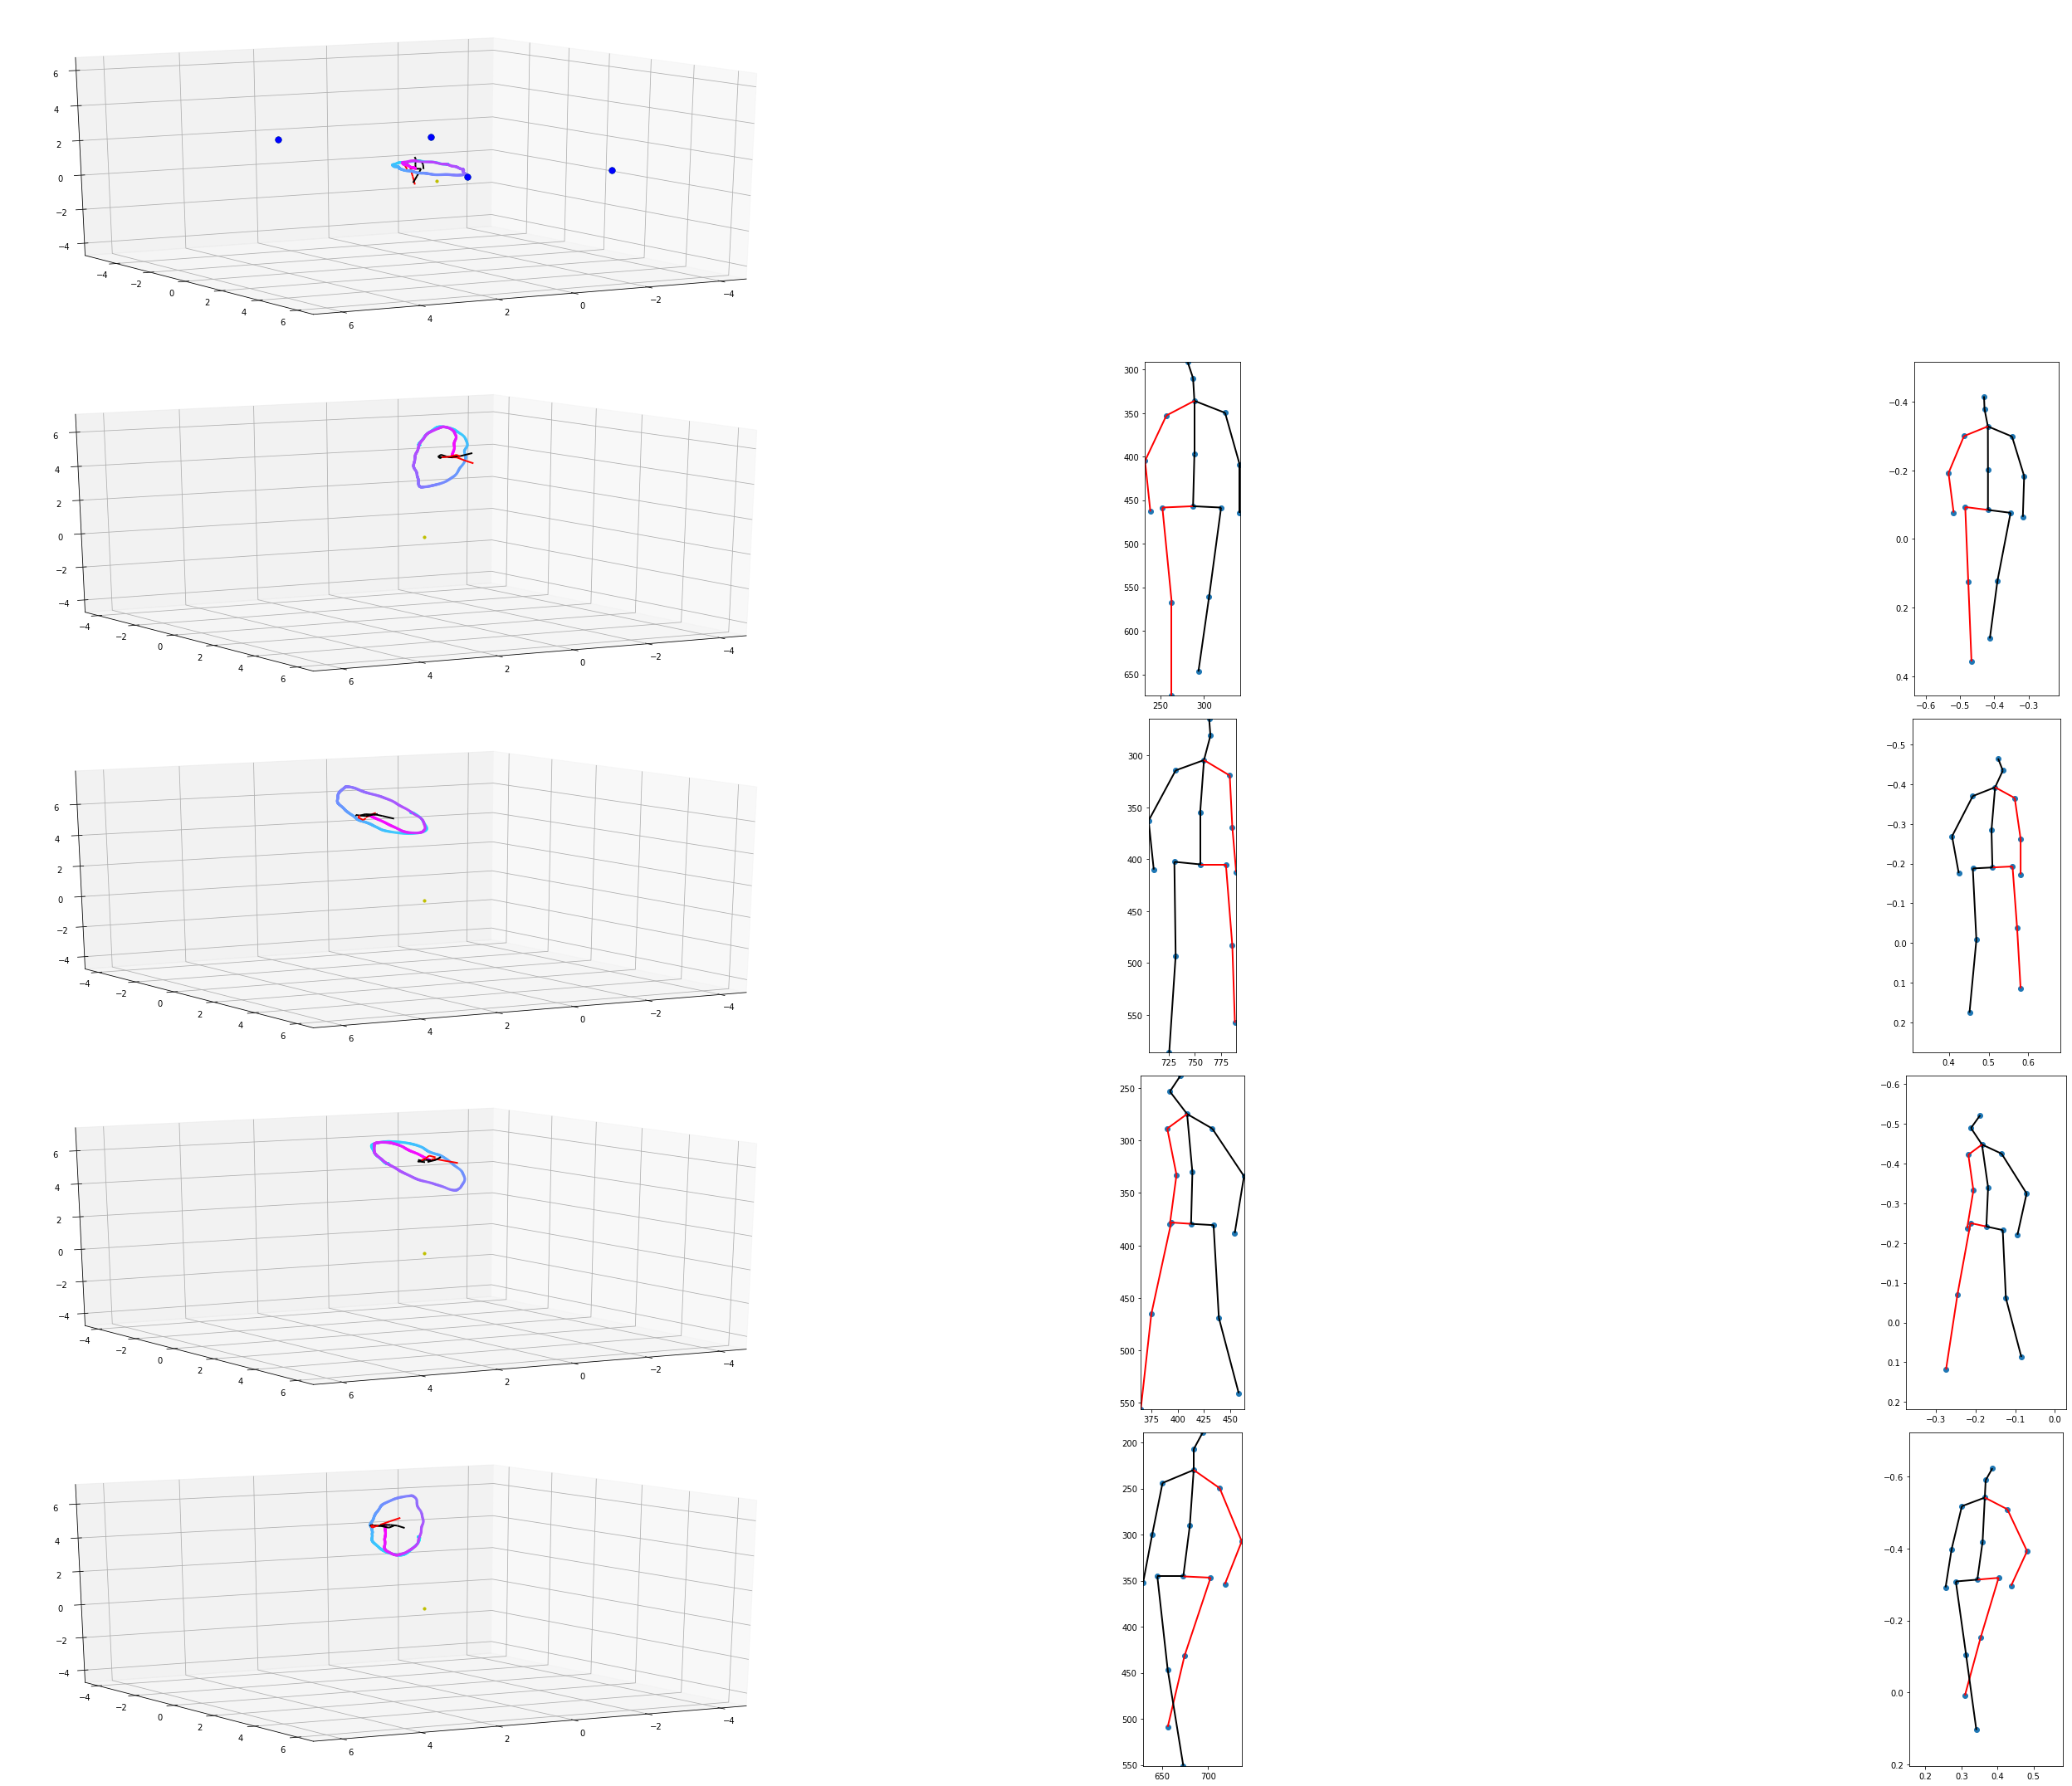

In [10]:
fig = plt.figure(figsize=(40,30))

m = 800

ax_3d_w = fig.add_subplot(5,3,1,projection='3d')
ax_3d_w = display_3D_skeleton_beta(ax_3d_w, gt[m], skeleton, [cam_0, cam_1, cam_2, cam_3])
ax_3d_w = display_trajectory(ax_3d_w, gt, m)

# cam 0
ax_3d_cam_0 = fig.add_subplot(5,3,4,projection='3d')
ax_3d_cam_0 = display_3D_skeleton_beta(ax_3d_cam_0, gt_cam_0[m], skeleton)
ax_3d_cam_0 = display_trajectory(ax_3d_cam_0, gt_cam_0, m)

ax_2d_cam_0_origin = fig.add_subplot(5,3,5, aspect='equal')
ax_2d_cam_0_origin = display_2D_skeleton_beta(ax_2d_cam_0_origin, keypoints_2d_cam_0[m], skeleton)

ax_2d_cam_0_reproj = fig.add_subplot(5,3,6, aspect='equal')
ax_2d_cam_0_reproj = display_2D_skeleton_beta(ax_2d_cam_0_reproj, reprojection(gt_cam_0[m], cam_0), skeleton)

# cam 1
ax_3d_cam_1 = fig.add_subplot(5,3,7,projection='3d')
ax_3d_cam_1 = display_3D_skeleton_beta(ax_3d_cam_1, gt_cam_1[m], skeleton)
ax_3d_cam_1 = display_trajectory(ax_3d_cam_1, gt_cam_1, m)

ax_2d_cam_1_origin = fig.add_subplot(5,3,8, aspect='equal')
ax_2d_cam_1_origin = display_2D_skeleton_beta(ax_2d_cam_1_origin, keypoints_2d_cam_1[m], skeleton)

ax_2d_cam_1_reproj = fig.add_subplot(5,3,9, aspect='equal')
ax_2d_cam_1_reproj = display_2D_skeleton_beta(ax_2d_cam_1_reproj, reprojection(gt_cam_1[m], cam_1), skeleton)

# cam 2
ax_3d_cam_2 = fig.add_subplot(5,3,10,projection='3d')
ax_3d_cam_2 = display_3D_skeleton_beta(ax_3d_cam_2, gt_cam_2[m], skeleton)
ax_3d_cam_2 = display_trajectory(ax_3d_cam_2, gt_cam_2, m)

ax_2d_cam_2_origin = fig.add_subplot(5,3,11, aspect='equal')
ax_2d_cam_2_origin = display_2D_skeleton_beta(ax_2d_cam_2_origin, keypoints_2d_cam_2[m], skeleton)

ax_2d_cam_2_reproj = fig.add_subplot(5,3,12, aspect='equal')
ax_2d_cam_2_reproj = display_2D_skeleton_beta(ax_2d_cam_2_reproj, reprojection(gt_cam_2[m], cam_2), skeleton)

# cam 3
ax_3d_cam_3 = fig.add_subplot(5,3,13,projection='3d')
ax_3d_cam_3 = display_3D_skeleton_beta(ax_3d_cam_3, gt_cam_3[m], skeleton)
ax_3d_cam_3 = display_trajectory(ax_3d_cam_3, gt_cam_3, m)

ax_2d_cam_3_origin = fig.add_subplot(5,3,14, aspect='equal')
ax_2d_cam_3_origin = display_2D_skeleton_beta(ax_2d_cam_3_origin, keypoints_2d_cam_3[m], skeleton)

ax_2d_cam_3_reproj = fig.add_subplot(5,3,15, aspect='equal')
ax_2d_cam_3_reproj = display_2D_skeleton_beta(ax_2d_cam_3_reproj, reprojection(gt_cam_3[m], cam_3), skeleton)
plt.tight_layout()
plt.show()